Basic Predictions
===============

This notebook tries to predict number of "confirmed cases" from patientdb available at http://api.covid19india.org/. 

Growth rate is computed as rate of change of confirmed cases and smoothened using a 7d rolling average.
It is extrapolated using the following methods:
* Quadartic curve fitting - fails to fit the curve correctly
* Hyperbolic curve fitting using a neural net - fits well and asymptotes the growth rate at ~7%.

The model is rudimentary and points towards a scenario where we fail to contain the epidemic and it eventually moves to stage 3/4.

In [4]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import matplotlib as mpl
from matplotlib.dates import date2num, AutoDateLocator, ConciseDateFormatter, DayLocator, AutoDateFormatter

import datetime as dt
import pandas as pd
import numpy as np
import requests

from sklearn.neural_network import MLPRegressor

In [35]:
resp = requests.get("https://api.covid19india.org/data.json")
ts = resp.json()['cases_time_series']

r = {
    "date": [],
    "confirmed": [],
    "deceased": [],
    "recovered": []
}

for d in ts:
    try:
        r['date'].append(dt.datetime.strptime(d['date'] + "2020", '%d %B %Y'))
        r['confirmed'].append(int(d['dailyconfirmed']))
        r['deceased'].append(int(d['dailydeceased']))
        r['recovered'].append(int(d['dailyrecovered']))
    except Exception as e:
        print(d['date'])
        tb.print_exc()

df = pd.DataFrame(data=r, index=r['date'], columns=['confirmed', 'deceased', 'recovered'])
df.sort_index(inplace=True)
df = df[31:][:] #drop Feb data
print("Records:", len(df))

Records: 71


,confirmed,deceased,recovered,total,growth,sma_growth
2020-05-06,3602,91,1161,53004,7.291203,6.978759
2020-05-07,3344,104,1475,56348,6.308958,7.101847
2020-05-08,3339,97,1111,59687,5.925676,6.966570
2020-05-09,3175,115,1414,62862,5.319416,6.743406
2020-05-10,4311,112,1669,67173,6.857879,6.664132


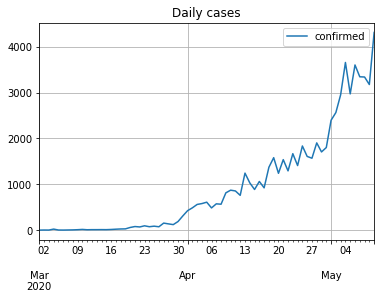

In [37]:
# cum sum
df['total'] = df['confirmed'].cumsum()

# calc growth rate & its moving avg
df['growth'] = 100 * df['confirmed'] / (df['total'] - df['confirmed'])
sma_gr = df['growth'].rolling(7).mean()
df['sma_growth'] = sma_gr

# daily plot
ax = df.plot(y='confirmed', kind='line', title="Daily cases", grid=True)
df.tail()

In [38]:
# create extrapolation dataframe
last_date = df.index[-1]
projections = pd.DataFrame(index=df.index.union(pd.date_range(start=last_date, periods=150, freq="1d")))

# fill with orig df
projections['confirmed'] = df['confirmed']
projections['total'] = df['total']
projections['sma_growth'] = df['sma_growth']
projections['day_of_yr'] = projections.index.dayofyear

# filter data for curve fitting (aka training data)
end_idx = len(df)
start_idx = end_idx - 35 # use 21 day sma data for curve fitting
fit_df = projections[start_idx:end_idx]
fit_df.tail()

,confirmed,total,sma_growth,day_of_yr
2020-05-06,3602.0,53004.0,6.978759,127
2020-05-07,3344.0,56348.0,7.101847,128
2020-05-08,3339.0,59687.0,6.966570,129
2020-05-09,3175.0,62862.0,6.743406,130
2020-05-10,4311.0,67173.0,6.664132,131


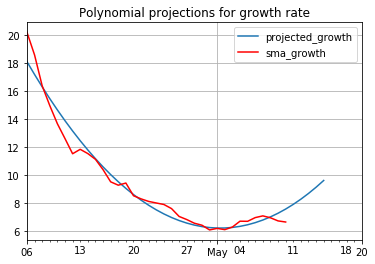

In [39]:
# fit polynomial curve
coeffs = np.polyfit(fit_df.day_of_yr, fit_df.sma_growth, 2) # 2nd degree
extrapolation_eqn = np.poly1d(coeffs)
projections['projected_growth'] = extrapolation_eqn(projections.day_of_yr)

# x axis ticks
mj_l = AutoDateLocator()
mj_f = ConciseDateFormatter(mj_l, show_offset=False)
mn_l = DayLocator()
       
ax = projections[start_idx:end_idx+5].plot(y='projected_growth', grid='True')
_ = projections[start_idx:end_idx+10].plot(y='sma_growth', color='red', grid=True, title="Polynomial projections for growth rate", ax=ax)

ax.xaxis.set_major_formatter(mj_f)
ax.xaxis.set_minor_locator(mn_l)

In [40]:
# train a neural network with hyperbolic activation function from day_of_yr => sma_growth
regressor = MLPRegressor(hidden_layer_sizes = (100,), activation = 'tanh', solver='lbfgs', max_iter=500)
_ = regressor.fit(X=fit_df[['day_of_yr']], y=fit_df['sma_growth'])

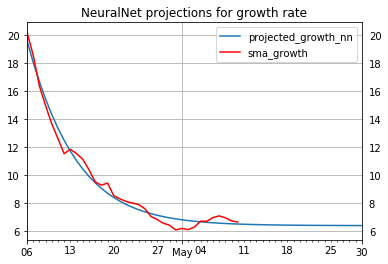

In [47]:
projections['projected_growth_nn'] = regressor.predict(X=projections[['day_of_yr']])
ax = projections[start_idx:end_idx+20].plot(
    y='projected_growth_nn', 
    grid=True
)
_ = projections[start_idx:end_idx+20].plot(
    y='sma_growth', 
    color='red', 
    title="NeuralNet projections for growth rate", 
    ax=ax, 
    grid=True
)

ax.xaxis.set_major_formatter(mj_f)
ax.xaxis.set_minor_locator(mn_l)
ax.tick_params(labeltop=False, labelright=True)

In [42]:
# compute total and daily numbers based on projected rate
prev_row_total = 0
def project(row):
    global prev_row_total
    if not np.isnan(row['total']):
        prev_row_total = row['total']
        return row['total']
    prev_row_total *= (1 + row['projected_growth_nn']/100)
    return prev_row_total

projections['projected_total'] = projections.apply(project, axis=1).astype('int64')

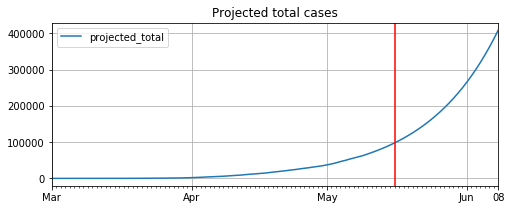

In [46]:
# plot 100 days from feb 1
ax = projections[0:100].plot(
    y='projected_total', 
    title="Projected total cases", 
    grid=True,
    figsize=(8,3)
)
ax.xaxis.set_major_formatter(mj_f)
ax.xaxis.set_minor_locator(mn_l)
ax.axvline(x=dt.datetime(day=16, month=5, year=2020), color='red')

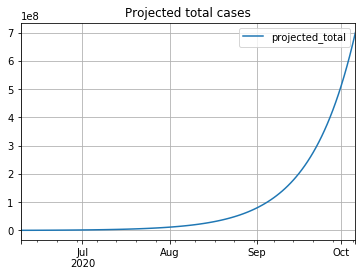

In [44]:
# plot next 100 days  
_ = projections[100:].plot(y='projected_total', title="Projected total cases", grid='True')